# Wikipedia Notable Life Expectancies

# [Notebook 5 of : Data Cleaning](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_06_23.ipynb)

## Context

The


## Objective

The

### Data Dictionary

- Feature: Description

## Importing Necessary Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean3.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean3", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 24 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,,None,volleyball player,Olympic champion coach,None,None,None,None,None,None,None,None,69.0,None,Russia,None,1980
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,engineer,member of the Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None,"China, People's Republic of",None,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
61001,11,Hilary Koprowski,", 96, Polish-born American virologist and immunologist, invented first effective live polio vaccine, pneumonia.",https://en.wikipedia.org/wiki/Hilary_Koprowski,24,2013,April,None,None,virologist immunologist,invented first effective live polio vaccine,pneumonia,None,None,None,None,None,None,None,96.0,None,Poland,United States of America,None
48627,2,Wu Jieping,", 94, Chinese medical scientist and politician.",https://en.wikipedia.org/wiki/Wu_Jieping,3,2011,March,None,None,medical scientist politician,None,None,None,None,None,None,None,None,None,94.0,None,"China, People's Republic of",None,None
19520,13,Chuck Schuldiner,", 34, American death metal guitarist, vocalist and songwriter, brain cancer.",https://en.wikipedia.org/wiki/Chuck_Schuldiner,31,2001,December,None,None,death metal guitarist,vocalist songwriter,brain cancer,None,None,None,None,None,None,None,34.0,None,United States of America,None,None
45738,12,Pius Njawé,", 53, Cameroonian journalist and activist, car accident.",https://en.wikipedia.org/wiki/Pius_Njaw%C3%A9,9,2010,July,None,None,journalist activist,car accident,None,None,None,None,None,None,None,None,53.0,None,Cameroon,None,None
112548,11,Sir Clem Renouf,", 99, Australian accountant, president of Rotary International .",https://en.wikipedia.org/wiki/Clem_Renouf,6,2020,June,,None,accountant,president of Rotary International,None,None,None,None,None,None,None,None,99.0,None,Australia,None,1978 1979


<IPython.core.display.Javascript object>

### Checking Data Types, Duplicates, and Null Values

In [5]:
# Checking data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132652 entries, 0 to 132651
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   day                132652 non-null  object 
 1   name               132652 non-null  object 
 2   info               132652 non-null  object 
 3   link               132652 non-null  object 
 4   num_references     132652 non-null  object 
 5   year               132652 non-null  int64  
 6   month              132652 non-null  object 
 7   info_parenth       49830 non-null   object 
 8   info_1             35 non-null      object 
 9   info_2             132604 non-null  object 
 10  info_3             62571 non-null   object 
 11  info_4             12605 non-null   object 
 12  info_5             1497 non-null    object 
 13  info_6             216 non-null     object 
 14  info_7             31 non-null      object 
 15  info_8             6 non-null       object 
 16  in

<IPython.core.display.Javascript object>

#### Observations:
- Due to the diversity of entries for `known_for`, we may need to prioritize entries for the extraction of this feature.
- To do so, we will proceed with typecasting num_references as integer, so we can determine which entries have more references.
- We will also make a copy of the `info_parenth` column, as we will alter that column and the information it contains is no longer present in the original `info` column.

#### Typecasting `num_references` as Integer

In [6]:
# Typecasting num_references as int64
df.loc[:, "num_references"] = df.loc[:, "num_references"].astype("int64")

<IPython.core.display.Javascript object>

### `num_references`

In [8]:
df["num_references"].describe()

count    132652.000000
mean          9.790406
std          19.436805
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         837.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

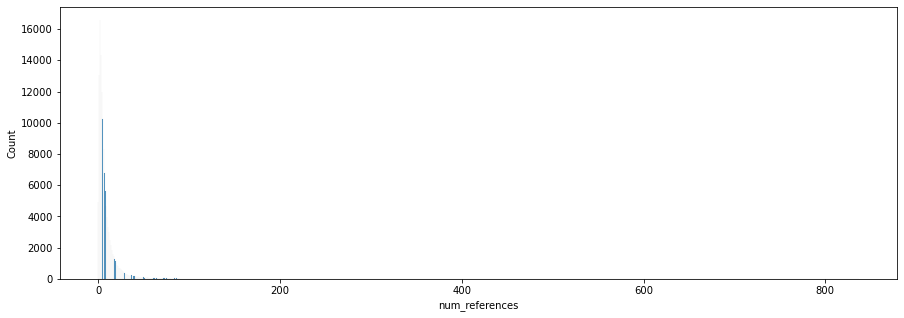

<IPython.core.display.Javascript object>

In [9]:
# Histplot of num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` is highly right skewed.
- We will verify some verifying of links to make sure the pages are for individuals.

In [10]:
# Example of verifying links (repeated in groups of 100 until num_references <100)
df.sort_values(by="num_references", ascending=False)[:10]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
36579,19,Bill Andress,", 83, American baseball umpire.",https://en.wikipedia.org/wiki/Bill_Andress,837,2008,May,None,None,baseball umpire,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None
11356,14,Frank Sinatra,", 82, American singer , heart attack.",https://en.wikipedia.org/wiki/Frank_Sinatra,660,1998,May,"""My Way"", ""That Life"" actor Oscar, winner",None,singer,heart attack,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,"""My Way"", ""That Life"" actor Oscar, 1954 winner"
35265,17,Bobby Fischer,", 64, American chess grandmaster, world champion , kidney failure.",https://en.wikipedia.org/wiki/Bobby_Fischer,631,2008,January,,None,chess grandmaster,world champion,kidney failure,None,None,None,None,None,None,None,64.0,None,United States of America,None,1972 1975
26014,11,Keith Miller,", 84, Australian Test cricketer, Australian rules footballer, fighter pilot and journalist.",https://en.wikipedia.org/wiki/Keith_Miller,586,2004,October,None,None,Test cricketer,rules footballer,fighter pilot journalist,None,None,None,None,None,None,None,84.0,None,Australia,Australia,None
35003,28,Benazir Bhutto,", 54, Pakistani opposition leader and former prime minister , assassinated.",https://en.wikipedia.org/wiki/Benazir_Bhutto,554,2007,December,",",None,opposition leader former prime minister,assassinated,None,None,None,None,None,None,None,None,54.0,None,Pakistan,None,"1988 1990, 1993 1996"
85511,25,Fidel Castro,", 90, Cuban politician, Prime Minister .",https://en.wikipedia.org/wiki/Fidel_Castro,531,2016,November,", President",None,politician,Prime Minister,None,None,None,None,None,None,None,None,90.0,None,Cuba,None,"1959 1976, President 1976 2008"
60287,5,Hugo Chávez,", 58, Venezuelan politician and military officer, President , heart attack.",https://en.wikipedia.org/wiki/Hugo_Ch%C3%A1vez,529,2013,March,since,None,politician military officer,President,heart attack,None,None,None,None,None,None,None,58.0,None,Venezuela,None,since 1999
97905,25,John McCain,", 81, American politician and Navy officer, member of the U.S. Senate , glioblastoma.",https://en.wikipedia.org/wiki/John_McCain,528,2018,August,since House of Representatives,None,politician Navy officer,member of the Senate,glioblastoma,None,None,None,None,None,None,None,81.0,None,United States of America,None,since 1987 House of Representatives 1983 1987
51541,20,Muammar Gaddafi,", 69, Libyan leader , shooting.",https://en.wikipedia.org/wiki/Muammar_Gaddafi,519,2011,October,,None,leader,shooting,None,None,None,None,None,None,None,None,69.0,None,Libya,None,1969 2011
105520,6,Robert Mugabe,", 95, Zimbabwean revolutionary and politician, President , cancer.",https://en.wikipedia.org/wiki/Robert_Mugabe,519,2019,September,Prime Minister,None,revolutionary politician,President,cancer,None,None,None,None,None,None,None,95.0,None,Zimbabwe,None,1987 2017 Prime Minister 1980 1987


<IPython.core.display.Javascript object>

#### Observations:
- Some links point to lists, such as the entry with the maximum `num_references` for Bill Andress.
- Also, there are several entries that point to a list of German World War II medal recipiants.
- We will make a list of these links and change their `num_references` values to 1.

In [11]:
# Creating list of links containing "German" with over 20 references
checklist = [
    index
    for index in df.index
    if "German" in df.loc[index, "info"] and df.loc[index, "num_references"] > 20
]
link_list = df.loc[checklist, "link"].tolist()

<IPython.core.display.Javascript object>

In [12]:
# # Code used to go verify links
# print(link_list.pop())

<IPython.core.display.Javascript object>

In [13]:
# List of links that point to pages with lists of individuals
link_is_list = [
    "https://en.wikipedia.org/wiki/Bill_Andress",
    "https://en.wikipedia.org/wiki/Joachim_Boosfeld",
    "https://en.wikipedia.org/wiki/Alfred_Eick",
    "https://en.wikipedia.org/wiki/Gerhard_Fischer_(soldier)",
    "https://en.wikipedia.org/wiki/Arthur_B%C3%BCssecke",
    "https://en.wikipedia.org/wiki/Hans-G%C3%BCnther_Lange",
    "https://en.wikipedia.org/wiki/Waldemar_von_Gazen",
    "https://en.wikipedia.org/wiki/Heinz_Angelmaier",
    "https://en.wikipedia.org/wiki/Herbert_Fries",
    "https://en.wikipedia.org/wiki/Friedrich_Carl_(officer)",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Altermann",
    "https://en.wikipedia.org/wiki/Paul_Brasack",
    "https://en.wikipedia.org/wiki/Walther_Gerhold",
    "https://en.wikipedia.org/wiki/Siegfried_Gerstner",
    "https://en.wikipedia.org/wiki/Alois_Schnaubelt",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Wiebe",
    "https://en.wikipedia.org/wiki/Hans-Hermann_Sturm",
    "https://en.wikipedia.org/wiki/Siegfried_Jamrowski",
    "https://en.wikipedia.org/wiki/Franz_Kieslich",
    "https://en.wikipedia.org/wiki/Wilhelm_Lehner",
    "https://en.wikipedia.org/wiki/Fritz_Langanke",
    "https://en.wikipedia.org/wiki/Achim_Wunderlich",
    "https://en.wikipedia.org/wiki/Viktor_Vitali",
    "https://en.wikipedia.org/wiki/Wilhelm_Noller",
    "https://en.wikipedia.org/wiki/Heinrich_Sonne",
    "https://en.wikipedia.org/wiki/Ludwig_Meister",
    "https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer",
    "https://en.wikipedia.org/wiki/Karl_Brommann",
    "https://en.wikipedia.org/wiki/Friedrich_Adrario",
    "https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz",
    "https://en.wikipedia.org/wiki/Hans-Georg_Borck",
    "https://en.wikipedia.org/wiki/Wilhelm_Weidenbr%C3%BCck",
    "https://en.wikipedia.org/wiki/Klaus_Feldt",
    "https://en.wikipedia.org/wiki/Erwin_Bachmann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz)",
    "https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Ba%E2%80%93Bm)",
    "https://en.wikipedia.org/wiki/Family_of_Barack_Obama#Stanley_Armour_Dunham",
    "https://en.wikipedia.org/wiki/Mbah_Gotho",
]

<IPython.core.display.Javascript object>

#### Changing `num_references` to 1 where Entry Link Points to a List Page

In [14]:
# Creating list of row indexes with links that point to lists
rows_to_treat = [index for index in df.index if df.loc[index, "link"] in link_is_list]

# Treating num_references for these entries
df.loc[rows_to_treat, "num_references"] = 1

# Checking a sample of rows
df.loc[rows_to_treat, :].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
65916,12,Heinz Angelmaier,", 95, German soldier, Hauptmann in World War II, awarded Knight's Cross of the Iron Cross.",https://en.wikipedia.org/wiki/Heinz_Angelmaier,1,2014,January,None,None,soldier,Hauptmann in World War II,awarded Knight Cross of the Iron Cross,None,None,None,None,None,None,None,95.0,None,Germany,None,None
27009,2,Hermann Dörnemann,", 111, German supercentenarian and World War I veteran, oldest living person in Germany, heart failure.",https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann,1,2005,March,None,None,supercentenarian World War I veteran,oldest living person in y,heart failure,None,None,None,None,None,None,None,111.0,None,Germany,None,None


<IPython.core.display.Javascript object>

#### Observations:
- With those entries treated, and the other top entries verified, let us take another look at the summary statistics and distribution of `num_references`.

In [15]:
# Summary statistics of updated num_references
df["num_references"].describe()

count    132652.000000
mean          9.734719
std          19.061117
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         660.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

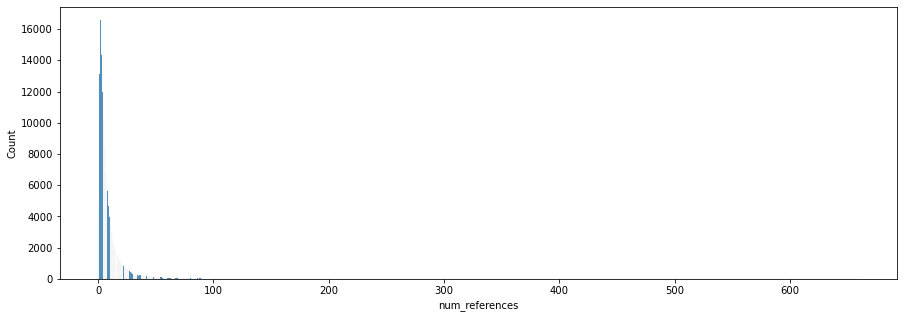

<IPython.core.display.Javascript object>

In [16]:
# Histplot of updated num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` remains highly right skewed.
- 25% of entries have 2 or fewer references, which may be a good cutoff to search for `known_for` values.
- Let us view the log transformation of the feature, both for the full dataset, and for `num_references` > 2.

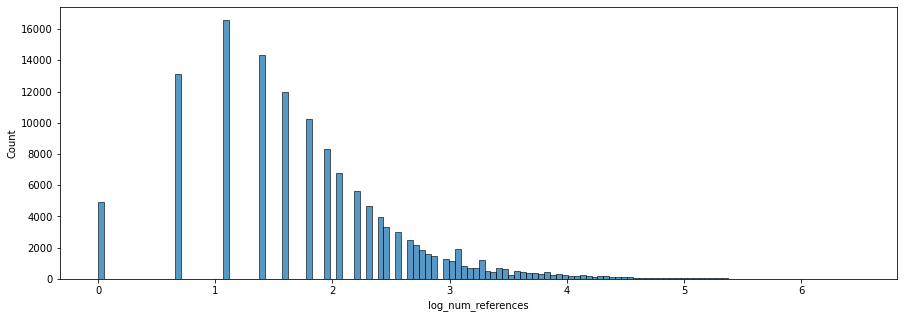

<IPython.core.display.Javascript object>

In [17]:
# Adding column for log_num_references
df["log_num_references"] = df["num_references"].apply(lambda x: np.log(x + 1))

# Histplot of log_num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="log_num_references")
plt.show()

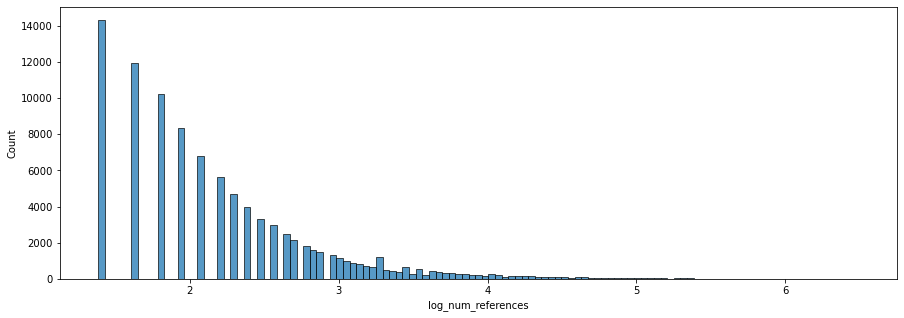

<IPython.core.display.Javascript object>

In [18]:
# Histplot of log_num_references where num_references > 2
plt.figure(figsize=(15, 5))
sns.histplot(data=df[df["num_references"] > 2], x="log_num_references")
plt.show()

#### Observations:
- The distribution is certainly more normalized with the log transformation, but follows a consistent curve for values > 2.
- For this analysis, we will focus on these more noted entries.

## Extracting `known_for` Data
Our goal will be to have some broader categories into which the specific values will fit.  `known_for` is a diverse feature, in that an individual may be known for a long-term role or roles, a specific event, a relationship with another person who is famous, etc.  So, to some extent we will see what we find and adapt as we go.

Also, we will abandon searching left to right as an individual may fit more than one category, and in no particular order.  For example, Ronald Reagan, is entered as "American actor and politician".  He is most known as the 40th president of The United States, so if we prioritized the first value, he would fit only into the category containing actor.  At the same time, it may have been his acting career that led to his political career.  Both arenas are relevant, so we will aim to capture all categories for an individual.  Later, when there are duplicate categories for an indivual, we can remove the redundant values.

We will take the following approach:
1. create and check a list of unique values in `info_2` that have a minimum number repeated, sufficient to create sets for each category, but not so exhaustive to be time prohibitive to manually enter.
2. using the pop() method, add each role to it's associated category's set, below.
3. combine the sets for each category into one dictionary.
4. Create a corresponding column for each category, initialized equal to 0.
4. search for the values in the dictionary and change the category column to 1 if match is found.

#### Restricting our Dataset to Entries with More than 2 References

In [19]:
# Limiting the dataset to entries with > 2 references
df = df[df["num_references"] > 2]
print(f"There are {len(df)} remaining entries in the dataframe.")

There are 98061 remaining entries in the dataframe.


<IPython.core.display.Javascript object>

#### Finding `known_for` Roles in `info_1`

In [20]:
# Obtaining values for column and their counts
roles_list = df["info_1"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [21]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category

In [22]:
# Creating lists for each category
politics_govt_law = [
    "politic",
]

arts = ["choral", "conductor", "journalist", "artist"]
sports = [
    "basketball",
    "Olymp",
    "gymnast",
    "sprinter",
    "sports",
]
sciences = ["materials scientist", "social psychologist", "psychologist"]

business = [
    "businessman",
    "businesswoman",
    "business",
]
academia_humanities = []
law_enf_military_operator = []
spiritual = []
social = []
# 'terrorist' will need separate treatment
crime = []
event_record_other = []
other_species = [
    "Tree",
    "chimpanzee",
]

<IPython.core.display.Javascript object>

In [23]:
# # Example code to quick-screen values that may overlap categories
# df.loc[[index for index in df.index if "King" in df.loc[index, "info"]], :]

<IPython.core.display.Javascript object>

#### Observations:
- We have a small start on `known_for_dict_1` values for which to search.
- Note that some roles such as sportswriter and sports broadcaster, though associated with sports, will also be included in arts, to align with the underlying nature of the work itself.
- Notes will be made in comments when the order of the categories in the dictionary matters during the search.
- Let us combine them into one dictionary.
- It appears we can collect `other_species` as we go, rather than needing our prior list. We will keep it to the side for now as values such as "racehorse" may interfere with extracting human entry values, such as "racehorse trainer".

#### Creating `known_for_dict_1` Dictionary of Category Keys and Specific Role Sets of Values

In [24]:
# Combining separate lists as sets into one dictionary
known_for_dict_1 = {
    "social": set(social),
    "spiritual": set(spiritual),
    "academia_humanities": set(academia_humanities),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
    #     "other_species": set(other_species),
}

<IPython.core.display.Javascript object>

#### Initializing `known_for` Category Columns

In [25]:
# Creating columns for each category
for category in known_for_dict_1:
    df[category] = 0

# Checking a sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other
118938,30,Alla Yoshpe,", 83, Russian pop singer, People's Artist of the Russian Federation .",https://en.wikipedia.org/wiki/Alla_Yoshpe,5,2021,January,,None,pop singer,People Artist of the Federation,None,None,None,None,None,None,None,None,83.0,None,Russia,None,2002,1.791759,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Extracting Category from `info_1`

In [26]:
%%time

# Dictionary version
search_dict = known_for_dict_1

# Column to check
column = 'info_1'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_set in search_dict.items():
    for role in category_set:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['politics_govt_law'] ==1].sample(2)

CPU times: total: 12.6 s
Wall time: 12.6 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other
87054,8,Mohamud Muse Hersi,", Somali politician, 79–80, President of Puntland .",https://en.wikipedia.org/wiki/Mohamud_Muse_Hersi,12,2017,February,,ian,None,President of Puntland,None,None,None,None,None,None,None,None,79.5,None,Somalia,None,2005 2009,2.564949,0,0,0,0,0,0,0,0,1,0,0
6832,17,Spiro Agnew,", American politician, 77, 39th Vice President of the United States, leukemia.",https://en.wikipedia.org/wiki/Spiro_Agnew,207,1996,September,None,ian,None,th Vice President of the,leukemia,None,None,None,None,None,None,None,77.0,None,United States of America,None,None,5.337538,0,0,0,0,0,0,0,0,1,0,0


<IPython.core.display.Javascript object>

In [27]:
# Checking remaining values in `info_1`
df["info_1"].value_counts()

                     7
ian                  2
ic                   2
early                2
man                  1
King of              1
leader               1
Jules Engel          1
Jr                   1
common chimpanzee    1
player               1
college  coach       1
Tree of the Year     1
Name: info_1, dtype: int64

<IPython.core.display.Javascript object>

#### Observations:
- Once again, the `info_1` column has provided a small sample on which to test our code, which appears to be working.
- We expect "King", "man", and "leader" to still be present, at this point.  There are some words, such as these, that used across different categories, so we will treat them carefully.
- When an entry has more than one role for the same category, the category value will still be equal to 1.
- We can proceed to `info_2`, which should have the bulk of the `known_for` information.

#### Finding `known_for` Roles in `info_2`

In [28]:
# Obtaining values for column and their counts
roles_list = df["info_2"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [29]:
# Code to check each value
roles_list.pop()

'television host  singer'

<IPython.core.display.Javascript object>

#### Appending Lists for Each `known_for` Category

In [30]:
# Appending lists for each category
politics_govt_law = politics_govt_law + [
    "entertainment attorney litigator",
    "Law Lord",
    "textbook campaigner",
    "campaigner",
    "Prime Minister President",
    "Prime Minister",
    "First Lady of the",
    "Western Shoshone leader",
    "environmental activist",
    "healthcare activist political commentator",
    "activist",
    "Clerk of Courts",
    "Senate President",
    "leader of the FNLA",
    "Labour Party MP",
    "Labour Party",
    "MP",
    "Chief Justice",
    "Emperor",
    "Chairman of the Assembly of Experts",
    "anti war activist",
    "chief minister",
    "wife of acting President Raúl Castro",
    "Representative from",
    "Yukon Party Leader",
    "Yukon Party",
    "Party Leader",
    "mayor",
    "Chief Minister",
    "presidential advisor",
    "national President",
    "District Court judge",
    "Justice",
    "judge",
    "diplomat",
    "legislat",
    "Court",
    "civil rights leader",
    "civil rights",
    "rights",
    "former President Nasser",
    "detainee",
    "Legislative Council",
    "Legislat",
    "Attorney General",
    "real estate attorney",
    "attorney",
    "tribal chief",
    "endangered species  advocate",
    "litigator",
    "advisor to Henry Kissinger",
    "senator",
    "Princess",
    "Ambassador",
    "nuclear arms control advocate",
    "republican",
    "Governor",
    "federal prosecutor",
    "Representative",
    "lawyer",
    "Deputy  Chief of Staff",
    "Progressive",
    "Conservative",
    "public health official",
    "mayor",
    "labor law expert member of Presidential commissions",
    "Liberal",
    "Democrat",
    "peer",
    "House of Lords",
    "Provisional  Republican Army founder member Northern  Assembly member",
    "jurist",
    "Teachta Dála",
    "aristocrat",
    "congress member",
    "Radio Peace",
    "Secretary of Interior",
    "Senator for",
]

arts = arts + [
    "television",
    "singer",
    "artist theorist in Arte Povera movement",
    "game artist",
    "graffiti artist",
    "make up artist",
    "artist",
    "rock manager",
    "porn producer",
    "photography curator",
    "photograph",
    "singer",
    "show contestant",
    "show",
    "contestant",
    "guitarist",
    "bass guitar player",
    "guitar",
    "broadcaster",
    "writer",
    "radio",
    "dramatist",
    "stage actor",
    "actor",
    "folk",
    "newspaper",
    "news",
    "anchorman",
    "anchorwoman",
    "anchor",
    "architect acoustician",
    "architect",
    "novelist",
    "author",
    "rhythm & blues",
    "vocalist",
    "painter",
    "talk show host",
    "host",
    "editor in chief",
    "editor",
    "dance",
    "choreograph",
    "playwright",
    "jazz",
    "tuba",
    "composer",
    "military journalist",
    "cartoonist",
    "keyboardist",
    "managing director of BBC Radio",
    "critic",
    "violin",
    "bass player",
    "bassist",
    "rapper ",
    "announcer",
    "commentator",
    "creator of the Howdy Doody puppet",
    "video",
    "columnist",
    "theatre producer",
    "theatr",
    "theater",
    "musician",
    "poet",
    "commentator",
    "film producer",
    "film",
    "stage actress",
    "stage manager",
    "stage director",
    "actress",
    "sculptor",
    "diarist",
    "founder of Sonnabend Gallery",
    "stunt",
    "performer",
    "screen",
    "impresario",
    "soul funk",
    "artistic director",
    "expert on the pipe organ",
    "pipe organ",
    "organist",
    "quilting",
    "owner of Factory Records",
    "cultural functionary",
    "movie",
    "narrator",
    "beer expert",
    "gamelan",
    "scriptwriter",
    "cast member",
    "drum",
    "bandleader",
    "band leader",
    "opera",
    "defence correspondent",
    "correspondent",
]
sports = sports + [
    "who was oldest living AFL VFL footballer",
    "cricket",
    "umpire",
    "fencing",
    "baseball",
    "rugby union footballer",
    "rugby union winger",
    "rugby union",
    "rugby",
    "football manager",
    "football",
    "wrestler",
    "Rodeo",
    "hiking",
    "athlet",
    "rower",
    "NHL",
    "drag racing",
    "hot rod",
    "swim",
    "World Rally",
    "motorcycle racer",
    "MotoGP racer",
    "explorer",
    "cheerleader",
    "soccer",
    "former general manager of Montreal Canadiens",
    "yokozuna",
    "bush walker",
    "wrestl",
]
sciences = sciences + [
    "physicist",
    "scientist in the field of human consciousness",
    "cognitive behavioral therapy",
    "researcher in artificial intelligence",
    "artificial intelligence",
    "engineer",
    "geneticist",
    "developmental biologist",
    "biologist",
    "acoustician",
    "electronics innovator",
    "polio cancer researcher",
    "astronomer",
    "atmospheric scientist",
    "meteorologist",
    "chemist",
    "information researcher",
    "radiolog",
    "director of SLAC",
    "who built Alaska first television station",  # Must go before arts
    "doctor",
    "inventor of the Nautilus exercise machines",
    "sociologist",
    "psychiatrist",
    "bee expert",
    "medical scientist",
    "ornitholog",
]

business = business + [
    "Matchbox Toys",
    "retail pioneer",
    "executive at MGM",
    "stockbroker",
    "founder of Bob Evans Restaurants",
    "banker",
    "labor leader",
    "chairman owner of Ellen Tracy sportswear",
    "founder of Princess Cruises",  # Must go before politics_govt_law
    "inventor of Rice a Roni",
    "entrepreneur",
    "home builder",
    "farm",
]
academia_humanities = academia_humanities + [
    "scholar translator of  literature",
    "Jewish Holocaust historian",  # Must come before spiritual
    "military historian",  # Must come before law_enf_military_operator
    "historian",
    "literary scholar",
    "scholar",
    "idealist philosopher",
    "social philosopher",
    "philospher",
    "idealist",
    "president of the University",
    "professor",
    "Professor",
    "expert on Latin",
    "curator",
    "archivist",
    "President of Gadjah Mada University",
]
law_enf_military_operator = law_enf_military_operator + [
    "army general",
    "army",
    "Taliban commander",
    "commander",
    "representative of the Abraham Lincoln Brigade",
    "soldier",
    "fighter pilot",
    "Air Force",
    "general for South  during the  War",
    "security agent",
    "marine",
    "Marine",
    "Medal of Honor",
    "World War II",
    "leader of the Anbar Salvation Council",
    "leader of Anbar Salvation Council",
    "airforce major general",
    "major general",
    "Air Marshal",
    "Army Officer",
    "intelligence service",
    "aviation",
    "security guard",
    "guerrilla",
]
spiritual = spiritual + [
    "Nonconformist minister",
    "cleric",
    "Jewish  Catholic Archbishop Emeritus of Paris",
    "Jewish",
    "Catholic",
    "Archibishop",
    "Patriarch of the  Orthodox Church",
    "Protopresbyter  of the  Orthodox Church",
    "Orthodox Church",
    "abbot",
    "evangelist",
    "theologian",
    "priest",
    "Anglican",
    "archbishop",
    "Protestant minister",
    "Protestant",
    "Archbishop",
    "religious mystic",
    "mystic",
    "rabbi",
    "chaplain",
    "second counselor in the First Presidency of the LDS Church",
    "evangel",
    "pastor",
]
social = social + ["socialite", "philanthrop"]
crime = crime + [
    "accused of involvement in attempt by Mehmet Ali Ağca to kill Pope John Paul II",
    "terrorist involved in the  Glasgow International Airport attack",
    'leader of the " Mafia"',
    "jailed for human rights abuses under Pinochet",
    "alleged child sex offender",
    "arranged the murder of his mistress",
]
event_record_other = event_record_other + [
    "oldest",
    "graduate",
    "Taliban hostage",
    "Son of Chris Benoit Nancy Benoit",
    "hate crime victim",
    "victim",
    "phone phreak",
    "survivor",
    "witness",
    "wrongly accused of the Atlanta Olympics bombing",
    "heaviest",
]
other_species = (  # Do not search until associated human values are in dictionary
    other_species
    + [
        "search rescue dog for September",
        "sacred bull",
        "thoroughbred racehorse",
        "orca at SeaWorld San Antonio",
        "orca",
        "parrot",
    ]
)

<IPython.core.display.Javascript object>

In [31]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "Bishop" in df.loc[index, "info"]], :,
# ]

<IPython.core.display.Javascript object>

In [32]:
## Example code to quick-check a specific entry
# df[df["info_2"] == "defence correspondent for"]

<IPython.core.display.Javascript object>

In [33]:
# Dropping entry that has <3 num_references due page is for event, etc.
# index = df[df["link"] == "https://en.wikipedia.org/wiki/Vivienne_Nearing"].index
# df.drop(index, inplace=True)
# df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

In [34]:
# Simplifying atypical value containing additional website
index = df[df["link"] == "https://en.wikipedia.org/wiki/Wyn_Harness"].index
df.loc[index, "info_2"] = "journalist"

<IPython.core.display.Javascript object>

#### Observations:
- Before hard-coding the category lists becomes to unwieldy, we can do an iteration to extract values using the current dictionary.
- We will save our current lists to `known_for_dict_1`, paying attention to the commented notes for order.
- For this iteration, we will withhold `other_species` as there are human entries containing racehorse, etc., that will not be in in the dictionary yet.

#### Updating `known_for_dict_1` Dictionary of Category Keys and Specific Role Sets of Values

In [35]:
# Combining separate lists as sets into one dictionary
known_for_dict_1 = {
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "spiritual": set(spiritual),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
    #     "other_species": set(other_species),
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict_1`

In [36]:
%%time

# Dictionary version
search_dict = known_for_dict_1

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_set in search_dict.items():
    for role in category_set:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['arts'] ==1].sample(2)

CPU times: total: 3min 54s
Wall time: 3min 54s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other
132542,2,Berndt Stübner,", 75, German actor , playwright and theatre director.",https://en.wikipedia.org/wiki/Berndt_St%C3%BCbner,8,2022,June,,None,,playwright theatre director,None,None,None,None,None,None,None,None,75.0,None,Germany,None,,2.197225,0,0,0,0,0,1,0,0,0,0,0
98825,15,Arto Paasilinna,", 76, Finnish novelist , complications from a stroke.",https://en.wikipedia.org/wiki/Arto_Paasilinna,30,2018,October,,None,,complications from a stroke,None,None,None,None,None,None,None,None,76.0,None,Finland,None,,3.433987,0,0,0,0,0,1,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Observations:
- We can create a new column, `num_categories`, to check how many categories each entry has.

#### Checking the Number of Rows without a First Category

In [37]:
# Checking the number of rows for each number of categories
df["num_categories"] = df[known_for_dict_1.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 21916 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- There are ~22,000 rows that are lacking a first category.
- We will create a second dictionary for the next iteration on `info_2`.

#### Finding `known_for` Roles in `info_2`

In [38]:
# Obtaining values for column and their counts on entries lacking any category
roles_list = df[df["num_categories"] == 0]["info_2"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [39]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [40]:
# Creating lists for each category and appending other_species list
politics_govt_law = [
    "ambassador",
    "Lord Mayor",
    "Chief Constable",
    "sheriff",
    "Senator",
    "member of the House of Commons",
    "Vice Premier",
    "NATO official",
    "government official",
    "Minister for Sport",
    "congressman",
    "congresswoman",
    "first administrator of the Autonomous Region",
    "shunned racial stereotypes in advertising",
    "Speaker of the  House of Commons",
    "servant to HM Queen Elizabeth",
    "Minister of Education",
    "Lord Provost",
    "Presidential candidate",
    "conservationist",
    "Mayor",
    "Foreign minister",
    "Finance Secretary",
    "Secretary",
    "Vice President of the  Commission",
    "local government official",
    "government official",
    "econom",
    "government adviser",
    "Republican leader",
    "First Lady",
    "presidential candidate",
    "Alliance for Democracy party",
    "chief of the Clan MacLeod",
    "representative",
    "minister for social welfare",
    "Sikh separatist leader",
    "transportation official",
]

arts = [
    "blues",
    "pianist",
    "BBC Radiophonic",
    "costume",
    "makeup",
    "drum",
    "rock band",
    "owner of Drury Lane Theatre",
    "accordian",
    "flavorist",
    "president of the Motion Picture",
    "founder of Portmeirion Pottery",
    "potter",
    "ceramicist",
    "ceramist",
    "pottery maker",
    "TV executive",
    "BBC reporter for Radio Kent",
    "BBC",
    "reporter",
    "Radio",
    "baritone",
    "manager of the Ramones",
    "former vice president of the Metropolitan Museum of Art",
    "Drum",
    "ceramics glazing master",
    "gay pornography producer",
    "bureau chief",
    "bookbinder",
    "Playmate",
    "publisher",
    "magazine",
    "First Lady of Song",  # Must come before politics_govt_law
    "producer president of ABC",
    "producer",
    "ABC",
    "flautist",
    "music teacher",
    "art collector",
    "lyricist",
    "cameraman",
    "founder of Judges Guild",  # Must come before politics_govt_law
]
sports = [
    "equestrian",
    "racing driver",
    "NASCAR",
    "slalom",
    "contract bridge",
    "martial arts",
    "jet car driver",
    "drag racer",
    "Commissioner of the  Football League",
    "Football",
    "former chairman of S L  Benfica",
    "world bridge",
    "NFL",
    "ski jump",
    "Grand Prix driver",
    "Ottowa Senators",  # Must come before politics_govt_law
    "boxer",
    "boxing",
    "Basketball",
    "NASCAR driver",
    "NASCAR",
    "golf",
    "PGA",
    "USAC champion midget car driver",
    "car driver",
    "leader of the  Intelligence Service",
    "Intelligence Service",
    "Intelligence",
    "ocean kayak adventurer",
    "kayak",
    "adventurer",
    "NHRA driver",
    "NHRA",
    "Baseball commissioner",
    "Baseball",
    "Philadelphia Athletics",
    "chairman of the AFL Commission",
    "AFL",
]
sciences = [
    "pediatric",
    "surgeon",
    "researcher in child psychology",
    "inventor of the TV",  # Check for TV
    "inventor",  # Check for inventor
    "urolog",
    "computer programmer",
    "periodont",
    "horticultur",
    "Physiology",
    "Medicine",
    "computer scientist chief designer of the Ada programming language",
    "who created APT  led MIT CAD project",
    "scientist",
    "cartograph",
    "developer of the Billings ovulation method",
    "physiolog",
    "pharmacolog",
]

business = [
    "trucking executive",
    "founding head of Air Tahiti Nui",
    "tire tycoon",
    "tycoon",
    "executive",
    "Wal Mart founder",
    "founder of Avis Rent a Car System",
    "real estate developer",
    "marketing executive",
    "co founder of Pat King of Steaks",
    "financier",
    "CEO",
    "retail",
    "president of United Steelworkers",
    "Cup Noodle",
    "Gaydar dating website",
    "president of Walgreens",
    "E & J Gallo Winery",
]
academia_humanities = [
    "Surveyor of the Queen Pictures",
    "world renowned literacy expert",
    "literacy expert",
    "founder of Tennessee Temple University",
    "anthropolog",
    "philosopher",
    "founder of the SAIS  Studies program",
    "lexicograph",
    "linguist",
]
law_enf_military_operator = [
    "Secret Intelligence Service",
    "captain of the Hokulea",
    "sheriff",
    "agent who led  Resistance saboteurs",
    "Federal Police assistant commissioner",
    "Federal Police",
    "Police",
    "astronaut in Mercury",
    "freedom fighter",
    "bomb disposal expert",
    "serviceman",
    "servicewoman",
    "KGB chief",
    "KGB",
    "spymaster",
    "pilot",
    "leader of  Tigers",
    "Army field marshal",
    "WWII Army leader",
    "airman",
    "WW I veteran",
    "veteran",
    "Watergate scandal principal",
    "firefighter",
    "rebel leader",
    "captain of the USS",
    "pilot",
    "Minister for Defence",
    "Defense Minister",
]
spiritual = [
    "Bishop of the Episcopal Diocese of Northern Michigan",
    "Bishop",
    "Episcopal",
    "religious cult leader",
    "cult leader",
    "brain injured girl claimed to have performed miracles",
    "bishop",
    "Muslim leader",
    "Muslim",
    "cardinal prefect",
    "cardinal",
    "president of Universal Life Church",
    "Holy Spirit Movement",
    "teacher of  Buddhism",
    "Buddh",
    "Rabbi",
]
social = [
    "philanthropist",
    "founder of Children World charity",
    "founder of the Emmaüs movement",
]
crime = [
    "fugitive",
    "mass murderer",
    "murderer",
    "convicted felon",
    "convicted of drug trafficking in",
    "convicted",
    "suspected drug lord high ranking leader of the Sinaloa Cartel",
    "drug lord",
    "spree killer",
]  # crime before event_record_other
event_record_other = [
    "teacher whose oxygen machine failed after power cut for unpaid account",
    "recipient of the first artificial heart transplant",
    "allegedly killed for refusing to wear hijab",
    "hermit",
    "murder",
    "brother in law of Osama bin Laden",
    "cheerleading fan of the Dallas Cowboys",
    "solicitor wrongly convicted of killing two of her sons",
]
other_species = other_species + [
    "race horse",
    "bucking bull",
    "Jack Russell terrier",
    "terrier",
    "Siberian tiger",
    "tiger",
]

# Starting cause_of_death list
cause_of_death = ["death from a fall off a bridge"]

<IPython.core.display.Javascript object>

In [41]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "representative" in df.loc[index, "info"]], :,
# ]

<IPython.core.display.Javascript object>

In [42]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "founder of Judges Guild"]

<IPython.core.display.Javascript object>

#### Observations:
- The dictionary is large enough to proceed with another iteration, checking `info_2`.

#### Creating `known_for_dict_2` Dictionary of Category Keys and Specific Role Sets of Values

In [43]:
# Combining separate lists as sets into one dictionary
known_for_dict_2 = {
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "spiritual": set(spiritual),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
    #     "other_species": set(other_species),
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict_2`

In [44]:
%%time

# Dictionary version
search_dict = known_for_dict_2

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_set in search_dict.items():
    for role in category_set:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['sports'] ==1].sample(2)

CPU times: total: 2min 15s
Wall time: 2min 15s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,num_categories
26985,27,Ed Clary,", 88, American football and baseball player.",https://en.wikipedia.org/wiki/Ed_Clary,6,2005,February,None,None,player,None,None,None,None,None,None,None,None,None,88.0,None,United States of America,None,None,1.945910,0,0,0,0,0,0,1,0,0,0,0,1
66379,3,Max Howell,", 86, Australian educator and rugby union player, cancer.",https://en.wikipedia.org/wiki/Max_Howell_(educator),3,2014,February,None,None,educator union player,cancer,None,None,None,None,None,None,None,None,86.0,None,Australia,None,None,1.386294,0,0,0,0,0,0,1,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [45]:
# Checking the number of rows for each number of categories
df["num_categories"] = df[known_for_dict_2.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 15829 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- ~7,000 entries had at least one category added on that iteration.
- We will repeat the process.

#### Finding `known_for` Roles in `info_2`

In [46]:
# Obtaining values for column and their counts on entries lacking any category
roles_list = df[df["num_categories"] == 0]["info_2"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [47]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [48]:
# Creating lists for each category and appending other_species list
politics_govt_law = [
    "stenographer",
    "turned opponent",
    "Communist revolutionary",
    "revolutionary",
    "Ku Klux Klan leader",
    "public health administrator",
    "private secretary",
    "Minister of Communications",
    "noble Infante",
    "noble",
    "Chief of Protocol",
    "Privacy Commissioner",
    "AIDS denialist",
    "Lord Lieutenant",
    "immigrant anti Castro lobbyist",
    "lobbyist",
    "military prosecutor",
    "public servant",
    "Black Panther member",
    "public leader",
]

arts = [
    "general manager of Montreux Jazz Festival",  # Must come before sports
    "general manager of the Metropolitan Opera",  # Must come before sports
    "gardening expert presenter",
    "presenter",
    "model",
    "fashion designer",
    "costumier",
    "press agent",
    "penciler of comic books",
    "comic",
    "illustrator",
    "caricatur",
    "music manager",
    "ukulele",
    "clown",
    "blog",
    "vlog",
    "textile printer",
    "science fiction expert",
]
sports = [
    "Karatedo",
    "karate",
    "Karate",
    "ice hockey",
    "hockey",
    "general manager",
    "runner",
    "race horse trainer",
    "snooker",
    "auto racing team owner",
    "auto racing",
    "Go player",
    "yachtsman",
    "mixed martial art fighter",
    "martial art",
    "rodeo",
    "Major League",
    "chess",
    "Chess",
]
sciences = [
    "dermatopatholog",
    "tank designer",
    "medical",
    "ichthyolog",
    "taxiderm",
    "geriatric",
    "developer of ventricular assist device",
    "physician",
    "suicidolog",
    "forestry expert",
    "leprolog",
    "botanist",
    "bryolog",
    "medical researcher",
    "physician",
]

business = [
    "credit union administrator",
    "creidit union",
    "general manager of SEPTA",  # Must come before sports
    "trade union official",
    "industrialist",
    "textile manufacturer",
    "manufacturer",
    "pharmaceuticals magnate",
    "financial",
    "labor organizer",
    "Monster com",
    "salesman",
]
academia_humanities = [
    "adult educator",
    "educator",
    "adult education innovator",
    "president of the Center for Libertarian Studies",
    "Faculty Emeritus",
    "university director",
    "president of Drexel University",
]
law_enf_military_operator = [
    "sergeant",
    "Victoria Cross",
    "Air Vice Marshal",
    "admiral naval aviator",
    "naval",
    "aviator",
    "admiral",
    "Admiral",
    "General Staff officer",
    "chief of the Mumbai Anti Terrorist Squad",
    "flying ace",
    "senior Hamas leader",
]
spiritual = [
    "missionary",
    "The Jesus Army",
    "Angelican",
    "Mormon",
    "prelate",
    "Baptist",
    "preacher",
]
social = [
    "humanitarian",
    "child welfare expert",
    "rescuer of Jews",
    "co founder of Habitat for Humanity International",
]
crime = [
    "moonshiner",
    "yakuza lord",
    "perjurer against Jomo tta",
    "perjurer",
    "gang member",
]
event_record_other = [
    "Shortest adult human",
    "Shortest",
    "patient in right to die case",
    "pedestrian allegedly assaulted by police at  G   summit protests",
    "teacher who named Pluto",
    "Albert Medal",
    "gay transgender youth",
]
other_species = other_species + ["racehorse", "service dog", "Presidential cat"]

<IPython.core.display.Javascript object>

In [49]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "salesman" in df.loc[index, "info"]], :,
# ]

<IPython.core.display.Javascript object>

In [50]:
# # Example code to quick-check a specific entry
# df[
#     df["info_2"]
#     == "influential Baptist preacher public leader from the North Eastern state of"
# ]

<IPython.core.display.Javascript object>

#### Observations:
- The dictionary is large enough to proceed with another iteration, checking `info_2`.

#### Creating `known_for_dict_3` Dictionary of Category Keys and Specific Role Sets of Values

In [51]:
# Combining separate lists as sets into one dictionary
known_for_dict_3 = {
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "spiritual": set(spiritual),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
    #     "other_species": set(other_species),
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict_3`

In [52]:
%%time

# Dictionary version
search_dict = known_for_dict_3

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_set in search_dict.items():
    for role in category_set:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['academia_humanities'] ==1].sample(2)

CPU times: total: 1min 15s
Wall time: 1min 15s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,num_categories
5472,9,Alistair Cameron Crombie,", 80, Australian zoologist and historian of science.",https://en.wikipedia.org/wiki/Alistair_Cameron_Crombie,8,1996,February,None,None,zoologist of science,None,None,None,None,None,None,None,None,None,80.0,None,Australia,None,None,2.197225,0,0,1,0,0,0,0,0,0,0,0,1
116058,1,Jorge Núñez Sánchez,", 73, Ecuadorian writer and historian, cancer.",https://en.wikipedia.org/wiki/Jorge_N%C3%BA%C3%B1ez_S%C3%A1nchez,3,2020,November,None,None,,cancer,None,None,None,None,None,None,None,None,73.0,None,Ecuador,None,None,1.386294,0,0,1,0,0,1,0,0,0,0,0,2


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [53]:
# Checking the number of rows for each number of categories
df["num_categories"] = df[known_for_dict_3.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 13017 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- That iteration captured at least the first category for ~ 3000 entries.
- We will repeat the process again.

#### Finding `known_for` Roles in `info_2`

In [54]:
# Obtaining values for column and their counts on entries lacking any category
roles_list = df[df["num_categories"] == 0]["info_2"].value_counts().index.tolist()

<IPython.core.display.Javascript object>

In [55]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [56]:
# Creating lists for each category and appending other_species list
politics_govt_law = [
    "civil servant United Nations disarmament official",
    "Chamber of Commerce",
    "NATO official",
    "State Department official",
    "colonial official",
    "Public Service official",
    "communist official",
    "Central  Agency official",
    "East y official",
    "top official in the rebel government",
    "press official under Richard M  Nixon Gerald R  Ford",
    "public official",
    "Federal Judicial  official",
    "forestry official",
    "Republican party official",
    "juridical official",
    "King of Wallis",
    "President of  Fish & Game Commission",
    "Communist party secretary",
    "LTTE senior negotiator",
    "opposition leader",
    "prime minister",
    "Cabinet Minister",
    "founder of the Popular Front for the Liberation of",
    "Director of the Office of Management Budget",
    "President of Federal Reserve Bank of",
    "senior member of al Qaeda",
    "Deputy Premier",
    "Māori leader",
    "Minister for Foreign Affairs",
    "founder of VHP",
    "Communist leader",
    "Politic",
    "Minister of Transport",
    "first President",
    "Minister of Industry",
    "Education Minister",
    "former Imperial Wizard of the Ku Klux Klan",
    "Black Panther",
    "Sultan",
    "sultan",
    "civil servant",
    "bureaucrat",
    "General Assembly",
    "rebel tribal leader",
    "tribal leader",
]

arts = [
    "Screen Actors Guild official",
    "accordion",
    "president of CBS",
    "decorative flag pioneer",
    "industrial designer",
    "glassmaker",
    "cinematograph",
    "winner of  Nobel Prize for Literature",
    "Celtic music",
    "creator of Dudley Do Right The Munsters",
    "promoter of punk rock",
    "punk rock",
    "comedian",
    "satirist",
]
sports = [
    "official scorer",
    "ic Association official",
    "player official",
    "South   official",
    "ing e official",
    "ic official",
    "hurdles",
    "hurdle",
    "majority owner of  St  Louis Rams",
    "rowing",
    "vice president of community relations for St  Louis Cardinals",
    "mountaineer",
    "jockey",
    "competitive eater",
    "owner of the Boston Red Sox",
    "promoter of Lucha Libre",
    "wheelchair marathoner paralympian",
    "marathon",
    "paralymp",
    "Paralymp",
    "first baseman",
    "track road racing cyclist",
    "track",
    "racing",
    "cyclist",
    "racer",
    "president of the International Ski Federation",
    "skier",
    "Boston Celtics",
]
sciences = [
    "developer of Clean Language",
    "anaesthe",
    "agriculturalist",
    "creator of Snobol Icon",
    "patholog",
    "disk drive pioneer",
    "autism researcher",
    "geolog",
]

business = [
    "accountancy",
    "trades union official",
    "union official",
    "brewer",
    "founder of Carl Jr  restaurants",
    "owner of Taillevent restaurant",
    "founder of freenode",
    "nightclub owner",
    "property developer",
    "publishing magnate",
    "magnate",
    "co founder of Häagen Dazs ice cream",
]
academia_humanities = [
    "academi",
    "university official",
    "official pronouncer",
    "education official",
    "founder of the  Holocaust Memorial Museum",
    "president of the Royal College of Psychiatrists",
]
law_enf_military_operator = [
    "intelligence official",
    "police official",
    "nazi officer",
    "nazi",
    "Waffen SS member  official",
    "official senior  of the SiPo SD",
    "Pentagon official",
    "last official   of World War I",
    "Chief of Staff of the Defense Forces",
    "Army major",
    "small arms expert",
    "director of the Coast Guard",
    "dean of the  Academy",
]
spiritual = [
    "beautified catholic teenager",
    "Islamic Scholer",
    "primate of the Church of",
]
social = [
    "George Cross",
    "Findhorn Foundation",
    "war heroine",
]
crime = [
    "partisan who assassinated  official Wilhelm Kube",
    "alleged spy",
    "member of the Detroit Partnership",
    "who hijacked a plane to",
    "Mafia boss",
]
event_record_other = [
    "last known native speaker of the Eyak language",
    "USAid worker in the  Kabul Serena Hotel attack",
    "last original tenant of the Empire State Building",
]
other_species = other_species + ["giraffe", "Library cat", "rescue dog"]

<IPython.core.display.Javascript object>

In [57]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "first President" in df.loc[index, "info"]], :,
# ]

<IPython.core.display.Javascript object>

In [58]:
# # Example code to quick-check a specific entry
# df[df["info_2"] == "of the  Academy"]

<IPython.core.display.Javascript object>

#### Creating `known_for_dict_4` Dictionary of Category Keys and Specific Role Sets of Values

In [59]:
# Combining separate lists as sets into one dictionary
known_for_dict_4 = {
    "social": set(social),
    "academia_humanities": set(academia_humanities),
    "spiritual": set(spiritual),
    "business": set(business),
    "sciences": set(sciences),
    "arts": set(arts),
    "sports": set(sports),
    "law_enf_military_operator": set(law_enf_military_operator),
    "politics_govt_law": set(politics_govt_law),
    "crime": set(crime),
    "event_record_other": set(event_record_other),
    #     "other_species": set(other_species),
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict_4`

In [60]:
%%time

# Dictionary version
search_dict = known_for_dict_4

# Column to check
column = 'info_2'

# Dataframe
dataframe = df[column].notna()

# For loop to find role in column and extract it as category
for category, category_set in search_dict.items():
    for role in category_set:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['academia_humanities'] ==1].sample(2)

CPU times: total: 1min 24s
Wall time: 1min 24s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,num_categories
34150,23,Ivan Hinderaker,", 91, American academic, chancellor of the University of California, Riverside .",https://en.wikipedia.org/wiki/Ivan_Hinderaker,7,2007,September,,None,c,chancellor of the University of,Riverside,None,None,None,None,None,None,None,91.0,None,United States of America,None,1964 1979,2.079442,0,0,1,0,0,0,0,0,0,0,0,0
72385,9,Jože Toporišič,", 88, Slovene linguist.",https://en.wikipedia.org/wiki/Jo%C5%BEe_Topori%C5%A1i%C4%8D,6,2014,December,None,None,,None,None,None,None,None,None,None,None,None,88.0,None,Slovenia,None,None,1.945910,0,0,1,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [61]:
# Checking the number of rows for each number of categories
df["num_categories"] = df[known_for_dict_4.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 10838 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will be switching gears to searching for the top value counts in `info_2`.  
- Before doing so, we will use the first 4 dictionaries to search the remaining numbered `info` columns, holding off on searching `info_parenth` until we have exhausted the search with all dictionaries and only if an entry is missing a category altogether.

#### Extracting Category from Remaining Numbered `info_` Columns with first 4 Dictionaries

In [62]:
%%time

# Dictionaries to search
search_dict_list = [known_for_dict_1, known_for_dict_2, known_for_dict_3, known_for_dict_4]

# Columns to check
cols_list = ['info_3',
            'info_4',
            'info_5',
            'info_6',
            'info_7',
            'info_8',
            'info_9',
            'info_10',
            'info_11']

# For loop to find role in column and extract it as category
for search_dict in search_dict_list:
    for column in cols_list:
        dataframe = df[column].notna()
        for category, category_set in search_dict.items():
            for role in category_set:
                for index in dataframe.index:
                    item = df.loc[index, column]
                    if item:
                        if role in item:
                            df.loc[index, category] = 1
                            df.loc[index, column] = item.replace(role, '').strip()

# Checking a sample of rows
df[df['law_enf_military_operator'] ==1].sample(2)

CPU times: total: 1h 23min 23s
Wall time: 1h 23min 28s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,social,spiritual,academia_humanities,business,sciences,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,num_categories
86593,19,Roman Jarymowycz,", 72, Austrian-born Canadian soldier and educator.",https://en.wikipedia.org/wiki/Roman_Jarymowycz,13,2017,January,None,None,,None,None,None,None,None,None,None,None,None,72.0,None,Austria,Canada,None,2.639057,0,0,1,0,0,0,0,1,0,0,0,2
126575,17,Abdul Jamil Khan,", 91, Pakistani doctor and hospital chairman.",https://en.wikipedia.org/wiki/Abdul_Jamil_Khan,6,2021,October,None,None,hospital ch,None,None,None,None,None,None,None,None,None,91.0,None,Pakistan,None,None,1.945910,0,0,0,0,1,0,0,1,0,0,0,2


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [96]:
#### Checking the number of rows for each number of categories
df["num_categories"] = df[known_for_dict_4.keys()].sum(axis=1)

print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 9432 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- That was a long-running cell.  Before proceeding further, we need to export our database and other_species list and start a new notebook.
- There are few individual entries we will address before doing so.

#### Hard-coding a Few Entries for Accuracy

In [97]:
# Extracting "dog attack" to cause_of_death to avoid other_species inclusion
index = df[df["link"] == "https://en.wikipedia.org/wiki/Death_of_Diane_Whipple"].index
df.loc[index, "cause_of_death"] = "dog attack"
df.loc[index, "info_3"] = None

<IPython.core.display.Javascript object>

In [98]:
# Extracting administrator as academia_humanities to known_for_1
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/John_Blackburn_(educator)"
].index
df.loc[index, "known_for_1"] = "academia_humanities"
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

In [99]:
# Removing administrator from entry as category will be captured with other info
index = df[df["link"] == "https://en.wikipedia.org/wiki/John_E._Otto"].index
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

In [100]:
# Extracting "complications of diverticulitis" to cause_of_death to remove "diver" from value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Emanuel_Steward"].index
df.loc[index, "cause_of_death"] = "complications of diverticulitis"
df.loc[index, "info_3"] = None

<IPython.core.display.Javascript object>

In [101]:
# Assigning arts to first known_for value for entry (individual is associated with arts and politics_govt_law)
index = df[df["link"] == "https://en.wikipedia.org/wiki/Pavel_Dost%C3%A1l"].index
df.loc[index, "info_1"] = "arts"

<IPython.core.display.Javascript object>

In [102]:
# Removing minister from entry as category will be captured with other info
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jean_Chamant"].index
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

In [103]:
# Assigning law_enf_military_operator to entry with woman to serve in Foreign Legion
index = df[df["link"] == "https://en.wikipedia.org/wiki/Susan_Travers"].index
df.loc[index, "known_for_1"] = "law_enf_military_operator"
df.loc[index, "info_2"] = None

<IPython.core.display.Javascript object>

## Exporting Dataset to SQLite Database [wp_life_expect_clean4.db]()

In [104]:
# Saving dataset in a SQLite database
conn = sql.connect("wp_life_expect_clean4.db")
df.to_sql("wp_life_expect_clean4", conn, index=False)

98061

<IPython.core.display.Javascript object>

## Exporting other_species List to [other_species.csv]()

In [105]:
# Convert other_species list to dataframe and save to csv -- overwriting existing csv file
other_species_df = pd.DataFrame({"species": other_species})
other_species_df.to_csv("other_species.csv", index=False)

# Chime notification when cell successfully executes
chime.success()

<IPython.core.display.Javascript object>